# Sistemas de Ecuaciones Lineales

Los sistemas de ecuaciones lineales son de suma importancia en las ciencias básicas, con aplicaciones en todas las ramas de la Física.

Con excepción de algunos casos puntuales, los sistemas de ecuaciones lineales son resueltos usualmente de forma numérica. Un ejemplo importante de sistemas de ecuaciones lineales corresponde a resolver ecuaciones diferenciales parciales bajo un método de discretización numérico.

Vamos a estudiar sistemas de la forma
$$
Ax = v,
$$
donde $A$ es una matrix que puede representar un operador diferencia o en general un conjunto de ecuaciones y queremos resolver el sistema para el vector $x$ con base en la solución $b$

## Algoritmo de eliminación de Gauss

El método más fundamental para resolver este tipo de ecuaciones es el método de Gauss.

* En la mayoría de los casos, trabaja de forma correcta
* Usualmente muy lento para ser útil en sistemas de un número grande de ecuaciones

Veamos el siguiente ejemplo:
$$A =
\begin{bmatrix}
6 & 5 \\
4 & 3
\end{bmatrix}, \qquad v = \binom{2}{1}.
$$ 
El problema a resolver, por ende, es
$$\begin{bmatrix}
6 & 5 \\
4 & 3
\end{bmatrix}\binom{x_1}{x_2} = \binom{2}{1}.
$$ 
Por lo tanto,
$$6x_1 + 5x_2 = 2,$$
$$4x_1 + 3x_2 = 1.$$
El método clásico se basa en 
1. Dividir la primera línea por el primer coeficiente:
$$x_1 + \frac{5}{6}x_2 = \frac{1}{3},$$
$$4x_1 + 3x_2 = 1$$
2. Hacer $4\times \text{1era ec.} - \text{2da ec.} = \text{nueva 2da ec.}$:
$$x_1 + \frac56x_2 = \frac13,$$
$$0x_1 + \frac13x_2 = \frac13,$$
lo cual implica $x_2=1$.
Más ecuaciones $\Rightarrow$ cancelar todos los primeros coeficientes de cada línea de manera equivalente.
3. Si hay más ecuaciones: se repite desde la segunda línea para eliminar todos los segundos coeficientes hacia abajo y se repite el proceso
4. Se utiliza sustitución hacia atrás: $x_2=1 \Rightarrow x_1 + 5/6 = 1/3 \Rightarrow x_1 = -1/2$.

## Implementación en `Python`

Este algoritmo se puede implementar en `Python` de la siguiente forma:

In [1]:
import numpy as np

def gausselim(A, v):
    N = len(v)
    # Eliminación Gaussiana
    for m in range(N): #Numero de filas
        # Dividimos por el elemento en la diagonal
        div = A[m, m]
        A[m, :] /= div #Dividimos toda la fila
        v[m] /= div #Dividimos todo el vector
        # Y ahora sustraemos de las ecuaciones hacia abajo
        for i in range(m+1, N):
            mult = A[i, m]
            A[i, :] -= mult*A[m, :]
            v[i] -= mult*v[m]
            #Nos da una matriz triangular superior
    # Sustitución hacia atrás
    x = np.zeros(N, float)
    for m in range(N-1, -1, -1):
        x[m] = v[m]
        for i in range(m+1, N):
            x[m] -= A[m, i]*x[i]
    
    return x

Utilicemos el código para nuestro ejemplo de arriba:

In [2]:
A1 = np.array([[6, 5], [4, 3]], float)  
V1 = np.array([2, 1], float)

gausselim(A1, V1)

array([-0.5,  1. ])

## Limitación de la eliminación de Gauss

El siguiente es un problema válido, sin embargo, hace que nuestro algoritmo no trabaje de manera correcta:
$$A =
\begin{bmatrix}
10^{-20} & 1 \\
1 & 1
\end{bmatrix}, \qquad v = \binom{1}{0}.$$
En teoría, $\displaystyle x \approx \binom{-1}{1}$. De acuerdo con nuestra rutina `gausselim`:

In [3]:
A2 = np.array([[1e-20, 1], [1, 1]], float)
V2 = np.array([1, 0], float)

gausselim(A2, V2)

array([0., 1.])

El problema es que tenemos un elemento diagonal muy cercano a cero! Con un valor de `0` en la diagonal, `Python` nos devuelve un error `ZeroDivisionError`.
En este caso, no tenemos ese error pero incurrimos en un error de redondeo muy grande.

Curiosamente, la rutina `numpy.linalg.solve` también devuelve el mismo resultado incorrecto!

In [4]:
np.linalg.solve(A2, V2)

array([0., 1.])

`SciPy` no nos devuelve un resultado correcto, pero al menos nos entrega una advertencia.

In [5]:
import scipy.linalg as la

la.solve(A2, V2)

/tmp/ipykernel_8221/1548001281.py:3: LinAlgWarning: Ill-conditioned matrix (rcond=1e-40): result may not be accurate.
  la.solve(A2, V2)


array([0., 1.])

## Pivoteo parcial

La metodología para resolver posibles divisiones entre cero o números muy cercanos a cero se llama **pivoteo parcial**. El algoritmo funciona de la siguiente forma:
1. En la fila $m$, evaluar cúal de las filas de abajo tiene el elemento $m$ mayor (en valor absoluto)
* Intercambiar esta fila con la fila del valor de $m$ en la iteración actual
* Proceder con eliminación Gaussiana

Veamos como se puede hacer esto en nuestro ejemplo. En este caso, solo tenemos dos filas para intercambiar, sin embargo, el procedimiento se puede hacer iterativamente para sistemas de más ecuaciones.

In [6]:
A3 = np.array([[1, 1], [1e-20, 1]], float)  # Filas intercambiadas
V3 = np.array([0, 1], float)  # Necesitamos intercambiar estas filas también

gausselim(A3, V3)

array([-1.,  1.])

# Descomposición matricial: Descomposición LU

Supongamos que tenemos un sistema $Ax= f$, donde $f$ depende de cierto parámetro o parámetros en un problema físico. Cuando cambiamos dicho parámetro, $f$ también cambia pero $A$ se mantiene constante. 

No queremos volver a evaluar todo el algoritmo de eliminación Gaussiana cada vez que cambiamos dicho parámetro. 

Los pasos de la emilinación Gaussiana siempre son los mismos así que se pueden realizar solo una vez y guardar el resultado. 

La eliminación Gaussiana de una matrix $A$ se puede expresar como una serie de multiplicaciones de matriz tal que $U = L_nL_{n-1}\cdots L_0A$ donde $U$ es **triangular superior** (i.e., el resultado de la eliminación Gaussiana):
$$
L^{-1} = L_n L_{n-1} \cdots L_0 \Rightarrow\ Ax =  LUx = f.
$$
La descomposición 
$$\boxed{LU = A}$$
se conoce como "descomposición LU" de la matrix $A$. La matrix $L$ es **triangular inferior**.

### Cómo se utiliza la descomposición LU en práctica?

* Supongamos que conocemos $L$ y $U$ después de descomponer $A$
* Con base en esta descomposición
$$Ax=f \Leftrightarrow Ux=L^{-1}f.$$
* Ahora tenemos **dos problemas de matrices triangulares: $Ux = y$ y $Ly = f$**.
* Dado que las matrices son triangulares, la sustitución hacia atrás es trivial!
* Este es el método utilizado en `numpy.linalg.solve(A, f)`
* `scipy.linalg.lu_solve(scipy.linalg.lu_factor(A), f)` es equivalente a `numpy.linalg.solve(A, f)`, sin embargo, `SciPy` nos da acceso a los pasos intermedios para hacer la descomposición de la matriz
* Una vez que se conoce la descomposición LU de la matriz $A$, no se necesita hacer de nuevo dado que podemos cambiar $f$ y solo tenemos que resolver el sistema triangular $Ly=f$ y $Ux=y$, los cuales son muy sencillos de resolver con la estructura triangular

### Limitaciones de la descomposición LU

La descompocisión LU falla cuando $A$ es singular o muy cercana a ser singular, como consecuencia de errores de redondeo. Una matriz $A$ es singular si su determinante $|A| = 0$, tal que $A^{-1}$ no puede ser definida ($A$ no es invertible).

Consideremos un ejemplo de una matrix singular:
$$A = 
\begin{bmatrix}
    1 & 2 \\ 2 & 4
\end{bmatrix}$$
Dependiendo del lado derecho del sistema de ecuaciones lineales, podemos encontrar que el sistema no tiene solución o alguno de los coeficientes no puede ser determinado.

Por ejemplo:
* $A\binom{x_1}{x_2} = \binom{3}{5}\rightarrow $ no podemos tener $x_1 + 2x_2 = 3$ y $= 5/2$ al mismo tiempo.

* $A\binom{x_1}{x_2} = \binom{3}{6}\rightarrow$ un número infinito de soluciones.

La descomposición LU no puede encontrar una solución cuando la solución no existe. Esto es de esperar, pero si la matriz no es singular si no muy cercana a ser singular, el método computacional también puede fallar. Consideremos
$$A = 
\begin{bmatrix}
    1 & 2 \\ 2 & 4+\delta
\end{bmatrix},$$
con $\delta$ muy pequeño comparado al resto de los coeficientes. La matriz no es singular pero la descomposición LU falla si $\delta$ es muy pequeño.

In [7]:
delta = 1e-16
A = np.array([[1, 2], [2, 4+delta]], float)
print(A)
v = np.array([3, 5], float)
np.linalg.solve(A, v)  # Devuelve un error si delta / 4 < precisión de máquina

[[1. 2.]
 [2. 4.]]


LinAlgError: Singular matrix

# Descomposición matricial: Descomposición QR para problemas de autovalores

En este caso, queremos obtener la solución al problema
$$
Av = \lambda v,
$$
donde los $v$ son los autovectores de $A$ con autovalores $\lambda$. El problema de autovalores es de suma importancia en la Física, en especial en la rama de la Física Cuántica.

De la misma forma, el problema se puede expresar como 
$$AV = V\Lambda,$$
con $V$ una matriz compuesta por los autovectores ortonormales y $\Lambda$ una matrix diagonal compuesta de los autovalores correspondientes.

Si la matriz $A$ es **simétrica real o Hermítica**, podemos resolver este problema con una descomposición QR. Los detalles de la siguiente derivación no son tan importantes. Basta con saber que el método es iterativo y no funciona para matrices que no sean simétricas reales o Hermíticas. Para estos casos, se deben realizar modificaciones al algoritmo.

### Algoritmo QR

* Comienza con aplicar el procedimiento de Gram-Schmidt sobre las columnas de A, el cual resulta en una matriz cuyas columnas conforman una base ortonormal a la cual llamamos $Q$
* Denotamos la descomposición como $QR$, tal que $A = QR$ con $R$ una matrix triangular superior
* Dado que Q es ortonormal $\Rightarrow\ Q^TQ=I\ \Rightarrow\ R = Q^TA$
* Realizamos la siguiente iteración:
  - $A = Q_1 R_1 \implies Q_1^T A = Q_1^T Q_1 R_1 = R_1$ --------------> Definimos $A_1$
  - $A_1 = R_1 Q_1 = Q_1^T A Q_1$ ------------------------------------>  Descomposición QR de $A_1$
  - $A_2 = R_2 Q_2 = Q_2^T A_1 Q_2 = \underbrace{Q_2^T\underbrace{Q_1^TA}_{R_1}Q_1}_{R_2}Q_2$ ------------> Definimos $A_2$
  - $A_2 = Q_2R_2$ --------------------------------------------------> Descomposición QR de $A_2$
  - $A_3 = \dots$ 
El procedimiento sigue iterando hasta obtener $A_k$, donde
$$
A_k = (Q_k^T \cdots Q_1^T) A (Q_1 \cdots Q_k).
$$
Se puede demostrar que para un valor de $k$ lo suficientemente grande, la matrix $A_k$ se convierte en una matrix diagonal. 

### Algoritmo QR en práctica

La mejor forma de aplicar el algoritmo QR es utilizando una biblioteca que optimiza el procedimiento de Gram-Schmidt y las multiplicaciones de las matrices.

`NumPy` contiene una aplicación relativamente eficiente de este algoritmo, aunque una de las versiones más óptimas al día de hoy forma parte de las bibliotecas para desarrolladores dentro de `Intel MKL`.

Aplicarlo en `NumPy` es muy sencillo:

In [ ]:
A = np.array([[2, 1], [1, 2]])

print('A:\n', A)

eig_vs, V = np.linalg.eigh(A)  # autovalores, autovectores
L = np.diag(eig_vs)  # np.diag construye un arreglo diagonal

print('\nAutovalores: ', eig_vs)
print('Autovectores:\n', V)

# Esperamos que AV = VD
print('\nAV:\n', np.dot(A, V))
print('VL:\n', np.dot(V, L))

A:
 [[2 1]
 [1 2]]

Autovalores:  [1. 3.]
Autovectores:
 [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]

AV:
 [[-0.70710678  2.12132034]
 [ 0.70710678  2.12132034]]
VL:
 [[-0.70710678  2.12132034]
 [ 0.70710678  2.12132034]]


#### Limitación del algoritmo QR

El método *np.linalg.eigh* solo se puede aplicar para matrices simétricas reales o Hermíticas.
Por ejemplo, para la matriz
$$ A =
\begin{bmatrix}
2 & 3 \\
1 & 2
\end{bmatrix}$$

In [ ]:
A = np.array([[2,3],[1,2]])
eig_vs, V = np.linalg.eigh(A)
L = np.diag(eig_vs)

print('AV:\n', np.dot(A, V))
print('VL:\n', np.dot(V, L)) 

AV:
 [[0.70710678 3.53553391]
 [0.70710678 2.12132034]]
VL:
 [[-0.70710678  2.12132034]
 [ 0.70710678  2.12132034]]


Note que $AV \neq \Lambda V$, de manera tal que el algoritmo QR introducido anteriormente falla en capturar los autovalores y autovectores de una matriz que no es simétrica.

Para evaluar la autodescomposición de una matrix no simétrica o no Hermítica, el procedimiento se debe modificar dando lugar a un algoritmo menos eficiente.

`NumPy` ya incluye implementaciones para este tipo de problemas, e.g.,:

In [ ]:
A = np.array([[2,3],[1,2]])
eig_vs, V = np.linalg.eig(A) # calculate eigenvalues & eigenvectors
L = np.diag(eig_vs)  # np.diag constructs a diagonal array

print('AV:\n', np.dot(A, V))
print('VL:\n', np.dot(V, L)) 

AV:
 [[ 3.23205081 -0.23205081]
 [ 1.8660254   0.1339746 ]]
VL:
 [[ 3.23205081 -0.23205081]
 [ 1.8660254   0.1339746 ]]


# Laboratorio

<div>
<img src="Fig1.png" width="500"/>
</div>

Considere el sistema de $N$ masas idénticas acopladas mediante resortes lineales como en el diagram anterior. Ignoramos efectos gravitacionales por simplicidad. Las vibraciones observadas en un sistema como este forman un modelo de las vibraciones elementales observadas en sólidos. Vamos a estudiar los modos de oscilación horizontales.

Denotamos como $a_i$ al desplazamiento de la masa $i$ relativo con su posición de equilibrio. Las ecuaciones de movimiento en este caso están dadas por la segunda ley de Newton:
$$
m \frac{{\rm d}^2 a_i}{{\rm d}t^2} = k(a_{i+1} - a_i) + k(a_{i-1} - a_i) + F_i,
$$
donde $m$ es la masa y $k$ la constante del resorte. Estas ecuaciones aplican para todas las masas excepto las masas en los extremos, para las cuales tenemos
$$
m \frac{{\rm d}^2 a_1}{{\rm d}t^2} = k(a_2 - a_1) + F_1,
$$
para la primera masa y 
$$
m \frac{{\rm d}^2 a_N}{{\rm d}t^2} = k(a_{N-1} - a_N) + F_N,
$$
para la última. Supongamos que introducimos una fuerza a la primera masa de la forma $F1 = Ce^{i\omega t}$, donde $C$ es constante. Este tipo de fuerza se justifica en modelos sencillos de sólidos dado que usualmente en estos sistemas tenemos fuerzas que salen como resultado de cargas interactuando con campos electromagnéticos. 

El resultado es que los "átomos" van a oscilar de alguna forma con frecuencia angular $\omega$, de manera tal que la solución de los desplazamientos de los átomos toma la forma
$$
a_i(t) = x_i e^{i \omega t}
$$
para todo $i$. La magnitud de $x_i$ controla la amplitud de vibración y su fase controla la fase de la vibración con respecto a la fuerza externa. Sustituyendo la solución en las ecuaciones diferenciales obtenemos 
\begin{align}
(\alpha - k)x_1 - kx_2 &= C \\
\alpha x_i - k x_{i-1} - k x_{i+1} &= 0 \\
(\alpha - k) x_N - k x_{N-1} &= 0,
\end{align}
donde $\alpha = 2k - m\omega^2$.

Este sistema se puede escribir de la forma $Ax = b$. 

Escriba una rutina que devuelve la matrix $A$ para este problema: 

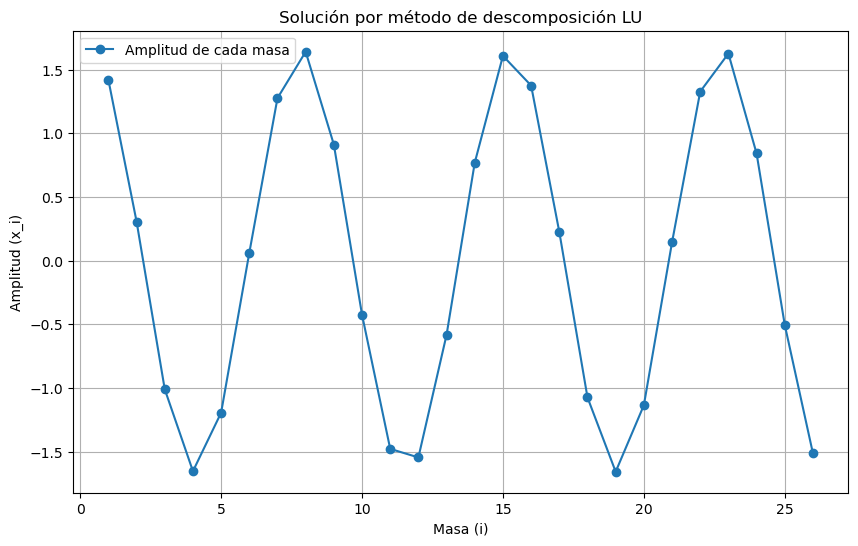

In [4]:
# Su código aquí
import scipy.linalg
import numpy as np
from scipy.linalg import lu_factor, lu_solve #Solamente para probar el LU
import matplotlib.pyplot as plt


def construir_matriz_A(N, alpha, k, C):

    #Se inicializa la matriz como una matriz tridiagonal
    A_matrix = np.zeros((N, N))
    
    #Se llena la diagonal principal
    np.fill_diagonal(A_matrix, alpha)
    
    #Se llenan las diagonales superior e inferior
    np.fill_diagonal(A_matrix[1:], -k)  # Diagonal inferior (valor = -k)
    np.fill_diagonal(A_matrix[:, 1:], -k)  # Diagonal superior (valor = -k)
    
    #Ajustar las condiciones de frontera
    A_matrix[0, 0] = alpha - k  # Primera fila (frontera izquierda)
    A_matrix[-1, -1] = alpha - k  # Última fila (frontera derecha)

    b_vector = np.zeros(N) #Construye el vector b
    b_vector[0] = C #Le asocia el valor C a la entrada 0 del vector b
    
    return A_matrix, b_vector

def Solution(A,b): #Solo para probar con Descomposición LU
    return scipy.linalg.lu_solve(scipy.linalg.lu_factor(A), b)

def gausselim(A, v): #Método de eliminación gaussiana
    N = len(v)
    # Eliminación Gaussiana
    for m in range(N): #Numero de filas
        # Dividimos por el elemento en la diagonal
        div = A[m, m]
        A[m, :] /= div #Dividimos toda la fila
        v[m] /= div #Dividimos todo el vector
        # Y ahora sustraemos de las ecuaciones hacia abajo
        for i in range(m+1, N):
            mult = A[i, m]
            A[i, :] -= mult*A[m, :]
            v[i] -= mult*v[m]
            #Nos da una matriz triangular superior
    # Sustitución hacia atrás
    x = np.zeros(N, float)
    for m in range(N-1, -1, -1):
        x[m] = v[m]
        for i in range(m+1, N):
            x[m] -= A[m, i]*x[i]
    
    return x

# Parámetros del sistema
N = 26  # Número de masas
C = 1  # Término independiente en la primera ecuación
m = 1  # Masa
w = 2  # Frecuencia angular
k = 6  # Constante del resorte
alpha = 2 * k - m * (w**2)  # Parámetro alpha

# Construir la matriz A y el vector b
A, b = construir_matriz_A(N, alpha, k, C)

x_vector1 = Solution(A,b) #Obtenemos su solución con LU

plt.figure(figsize=(10, 6))
plt.plot(range(1, N+1), x_vector1, 'o-', label='Amplitud de cada masa')
plt.xlabel('Masa (i)')
plt.ylabel('Amplitud (x_i)')
plt.title('Solución por método de descomposición LU')
plt.grid(True)
plt.legend()
plt.show()

Considere el caso: $N = 26$, $C = 1$, $m = 1$, $k = 6$ y $\omega = 2$. Utilice el método `gausselim` para hacer un gráfico de las amplitudes de oscilación de cada masa en el sistema.

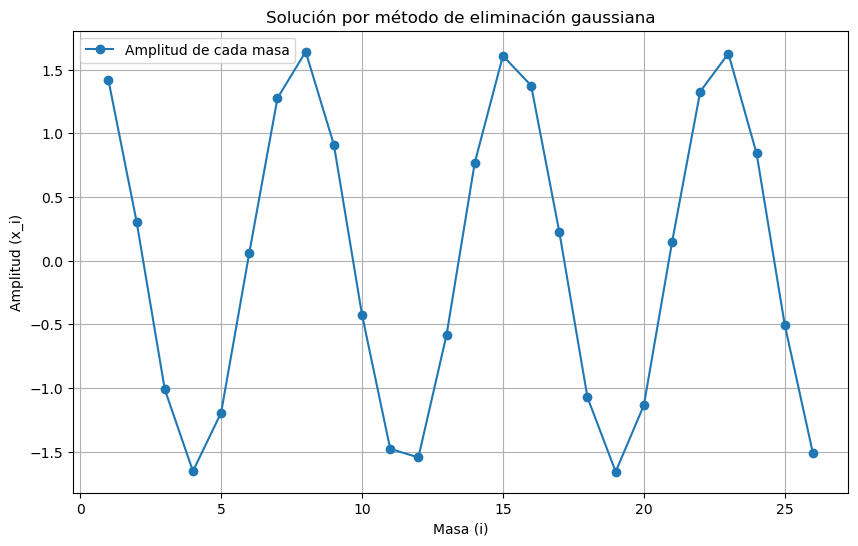

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# Parámetros del sistema
N = 26  # Número de masas
C = 1  # Término independiente en la primera ecuación
m = 1  # Masa
w = 2  # Frecuencia angular
k = 6  # Constante del resorte
alpha = 2 * k - m * (w**2)  # Parámetro alpha

# Construir la matriz A y el vector b
A, b = construir_matriz_A(N, alpha, k, C)

# Resolver el sistema usando gausselim
x_vector = gausselim(A, b)

# Graficar las amplitudes de cada masa
plt.figure(figsize=(10, 6))
plt.plot(range(1, N+1), x_vector, 'o-', label='Amplitud de cada masa')
plt.xlabel('Masa (i)')
plt.ylabel('Amplitud (x_i)')
plt.title('Solución por método de eliminación gaussiana')
plt.grid(True)
plt.legend()
plt.show()

El método `gausselim` es sumamente ineficiente para este problema, dado que la matriz es tridiagonal. Utilice el método `solve_banded` de `SciPy` para encontrar la solución

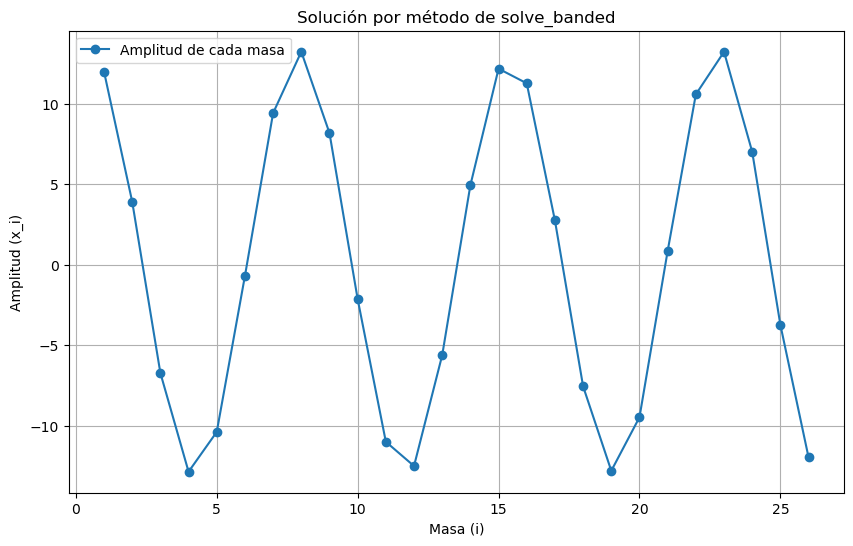

In [31]:
from scipy.linalg import solve_banded

#Creamos los arrays para trabajar con el banded
def matrix_banded(N,alpha,k):
    diag_sup = np.full(N-1,-k)
    diag_cent = np.full(N,alpha)
    diag_inf = np.full(N-1,-k)

    diag_cent[0] = alpha - k  # Última fila (frontera izquierda)
    diag_cent[-1] = alpha - k # Última fila (frontera derecha)

    ab = np.zeros((3,N))
    ab[0,1:] = diag_sup
    ab[1,:] = diag_cent
    ab[2,:-1] = diag_inf

    return ab

A_banded = matrix_banded(N,alpha,k) #Llama a la función

x_vector = solve_banded((1,1),A_banded,b) #Genera el vector

# Graficar las amplitudes de cada masa
plt.figure(figsize=(10, 6))
plt.plot(range(1, N+1), x_vector, 'o-', label='Amplitud de cada masa')
plt.xlabel('Masa (i)')
plt.ylabel('Amplitud (x_i)')
plt.title('Solución por método de solve_banded')
plt.grid(True)
plt.legend()
plt.show()